
# Práctica – Extracción y Análisis desde MySQL (Tablas **usuarios** y **boletos**)

> **Objetivo:** Conectar a una base de datos **MySQL**, extraer información de las tablas `usuarios` y `boletos`, realizar consultas claves, crear un *dataset* integrado y generar visualizaciones y archivos de salida.

**Requisitos previos**  
- MySQL 8+ con tablas `usuarios` y `boletos` 
- Usuario con permisos de `SELECT`.  
- Librerías de Python: `pandas`, `SQLAlchemy`, `PyMySQL`, `matplotlib`.

In [2]:

# =========================
# 1) Configuración
# =========================
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

MYSQL_USER = "root"
MYSQL_PASSWORD = "edgar2411"
MYSQL_HOST = "localhost"
MYSQL_PORT = 3309
MYSQL_DB = "apibus" 

# Crea el engine de SQLAlchemy usando PyMySQL
engine = create_engine(
    f"mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DB}",
    pool_pre_ping=True,
    pool_recycle=3600,
)

print("Conexión preparada (se probará en el siguiente paso).")


Conexión preparada (se probará en el siguiente paso).


In [3]:

# =========================
# 2) Probar conexión
# =========================
with engine.connect() as conn:
    version = conn.execute(text("SELECT VERSION()")).scalar()
    print("Versión de MySQL:", version)


Versión de MySQL: 8.0.32


In [3]:

# =========================
# 3) Lectura de tablas base
# =========================
query_usuarios = """
SELECT
    id,
    persona_id,
    usuario,
    correo_electronico,
    telefono,
    contrasena_hash,
    estado,
    is_active,
    is_staff,
    fecha_registro,
    ultima_conexion,
    created_at,
    updated_at
FROM usuarios;
"""

query_boletos = """
SELECT
    id,
    usuario_id,
    ruta_id,
    autobus_id,
    horario_id,
    fecha_reservacion,
    fecha_viaje,
    asiento_numero,
    estado,
    precio,
    created_at,
    updated_at
FROM boletos;
"""

with engine.connect() as conn:
    df_usuarios = pd.read_sql(text(query_usuarios), conn)
    df_boletos  = pd.read_sql(text(query_boletos), conn)

print("Usuarios:", df_usuarios.shape)
print("Boletos :", df_boletos.shape)

# Vista rápida
display(df_usuarios.head(3))
display(df_boletos.head(3))


Usuarios: (40, 13)
Boletos : (206, 12)


,id,persona_id,usuario,correo_electronico,telefono,contrasena_hash,estado,is_active,is_staff,fecha_registro,ultima_conexion,created_at,updated_at
0,1,1,elenora_franey,elenora_franey66@yahoo.com,744.257.1032 x879,$2b$10$HZvDq.uktLS.O/0IgLQzNONkLJbpt0gBEWpYgj5...,activo,1,1,2025-08-10 19:22:03,2025-08-10 19:22:03,2025-08-10 19:22:03,2025-08-10 19:22:03
1,2,2,emily.balistreri98,emily_balistreri@gmail.com,720.532.3781 x9041,$2b$10$iwA5wC7qBvGjFKmMQNIyT.AbHWzolsBkE891aws...,activo,1,1,2025-08-10 19:22:03,2025-08-10 19:22:03,2025-08-10 19:22:03,2025-08-10 19:22:03
2,3,3,vesta_feest98,vesta.feest@hotmail.com,478-949-0844 x321,$2b$10$04Mg/y/2hsmxNXmtMfrnc.Vi7YPonchdfJxOkct...,activo,1,1,2025-08-10 19:22:03,2025-08-10 19:22:03,2025-08-10 19:22:03,2025-08-10 19:22:03


,id,usuario_id,ruta_id,autobus_id,horario_id,fecha_reservacion,fecha_viaje,asiento_numero,estado,precio,created_at,updated_at
0,1,1,16,2,46,2025-08-10 19:22:09,2025-08-25,38.0,reservado,542.87,2025-08-10 19:22:09,2025-08-10 19:22:09
1,2,1,25,11,73,2025-08-10 19:22:09,2025-08-15,29.0,cancelado,540.86,2025-08-10 19:22:09,2025-08-10 19:22:09
2,3,1,19,5,57,2025-08-10 19:22:09,2025-08-22,16.0,completado,222.99,2025-08-10 19:22:09,2025-08-10 19:22:09


In [4]:

# =========================
# 4) Dataset integrado (JOIN)
# =========================
# Unimos boletos con info del usuario (1..n)
df_bu = df_boletos.merge(
    df_usuarios[['id','usuario','correo_electronico','estado','is_active','is_staff']],
    left_on='usuario_id', right_on='id', how='left', suffixes=('_boleto','_usuario')
)

# Limpieza de nombres
df_bu = df_bu.rename(columns={
    'id_boleto': 'id_boleto' if 'id_boleto' in df_bu.columns else 'id',
    'estado_usuario': 'estado_usuario',
    'estado': 'estado_boleto'
}).copy()

# Asegurar tipos de fecha
for col in ['fecha_reservacion','fecha_viaje','created_at','updated_at']:
    if col in df_bu.columns:
        df_bu[col] = pd.to_datetime(df_bu[col], errors='coerce')

print("Dataset integrado (boletos + usuario):", df_bu.shape)
df_bu.head(5)


Dataset integrado (boletos + usuario): (206, 18)


,id_boleto,usuario_id,ruta_id,autobus_id,horario_id,fecha_reservacion,fecha_viaje,asiento_numero,estado_boleto,precio,created_at,updated_at,id_usuario,usuario,correo_electronico,estado_usuario,is_active,is_staff
0,1,1,16,2,46,2025-08-10 19:22:09,2025-08-25,38.0,reservado,542.87,2025-08-10 19:22:09,2025-08-10 19:22:09,1,elenora_franey,elenora_franey66@yahoo.com,activo,1,1
1,2,1,25,11,73,2025-08-10 19:22:09,2025-08-15,29.0,cancelado,540.86,2025-08-10 19:22:09,2025-08-10 19:22:09,1,elenora_franey,elenora_franey66@yahoo.com,activo,1,1
2,3,1,19,5,57,2025-08-10 19:22:09,2025-08-22,16.0,completado,222.99,2025-08-10 19:22:09,2025-08-10 19:22:09,1,elenora_franey,elenora_franey66@yahoo.com,activo,1,1
3,4,1,25,11,74,2025-08-10 19:22:09,2025-08-24,21.0,reservado,540.86,2025-08-10 19:22:09,2025-08-10 19:22:09,1,elenora_franey,elenora_franey66@yahoo.com,activo,1,1
4,5,1,25,11,73,2025-08-10 19:22:09,2025-09-11,11.0,cancelado,540.86,2025-08-10 19:22:09,2025-08-10 19:22:09,1,elenora_franey,elenora_franey66@yahoo.com,activo,1,1


In [5]:

# =========================
# 5) KPIs y agregaciones principales
# =========================

total_boletos = len(df_boletos)
usuarios_unicos = df_boletos['usuario_id'].nunique()
precio_total = df_boletos['precio'].fillna(0).sum()
precio_prom = df_boletos['precio'].fillna(0).mean()

print(f"Total de boletos: {total_boletos}")
print(f"Usuarios con boletos: {usuarios_unicos}")
print(f"Ingreso total (boletos): ${precio_total:,.2f}")
print(f"Precio promedio: ${precio_prom:,.2f}")

# Boletos por estado
boletos_por_estado = df_boletos['estado'].value_counts().reset_index()
boletos_por_estado.columns = ['estado','total']
boletos_por_estado


Total de boletos: 206
Usuarios con boletos: 40
Ingreso total (boletos): $79,676.46
Precio promedio: $386.78


,estado,total
0,reservado,82
1,cancelado,65
2,completado,59


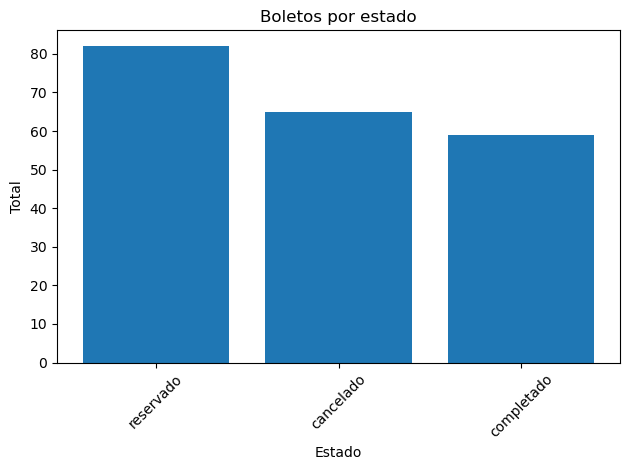

In [6]:

# =========================
# 6) Visualizaciones
# =========================
# 6.1) Boletos por estado
plt.figure()
plt.bar(boletos_por_estado['estado'].astype(str), boletos_por_estado['total'])
plt.title('Boletos por estado')
plt.xlabel('Estado')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


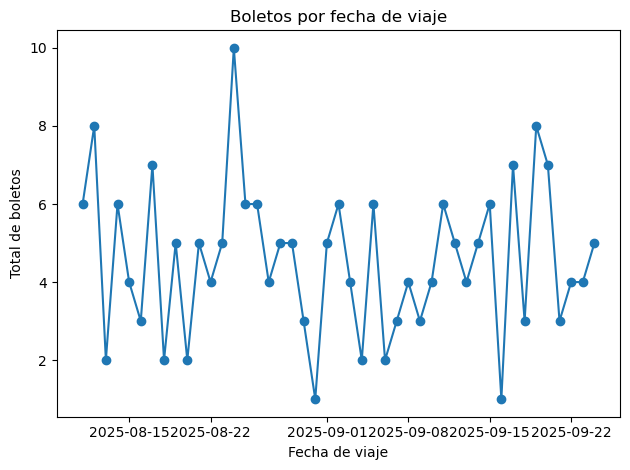

In [7]:

# 6.2) Boletos por fecha de viaje (línea diaria)
if 'fecha_viaje' in df_boletos.columns:
    serie = (
        df_boletos
        .dropna(subset=['fecha_viaje'])
        .assign(fecha_viaje=lambda d: pd.to_datetime(d['fecha_viaje'], errors='coerce'))
        .groupby('fecha_viaje')['id']
        .count()
        .sort_index()
    )
    if len(serie) > 0:
        plt.figure()
        plt.plot(serie.index, serie.values, marker='o')
        plt.title('Boletos por fecha de viaje')
        plt.xlabel('Fecha de viaje')
        plt.ylabel('Total de boletos')
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos válidos en fecha_viaje para graficar.")
else:
    print("La columna fecha_viaje no existe en df_boletos.")


,usuario_id,usuario,correo_electronico,gasto_total
0,23,rahul_hermiston,rahul_hermiston@hotmail.com,5306.67
1,28,dorothy.johnston49,dorothy_johnston38@gmail.com,4535.22
2,1,elenora_franey,elenora_franey66@yahoo.com,4155.41
3,19,jennifer_jerde32,jennifer_jerde@yahoo.com,3965.75
4,40,liam.abernathy36,liam_abernathy@yahoo.com,3704.82
5,5,leta_rodriguez26,leta.rodriguez62@yahoo.com,3560.72
6,20,otha.braun,otha.braun@hotmail.com,3508.54
7,27,ida.klein,ida_klein93@hotmail.com,3357.25
8,36,joany.smitham97,joany.smitham@yahoo.com,3221.34
9,6,paolo.frami31,paolo.frami73@hotmail.com,3028.20


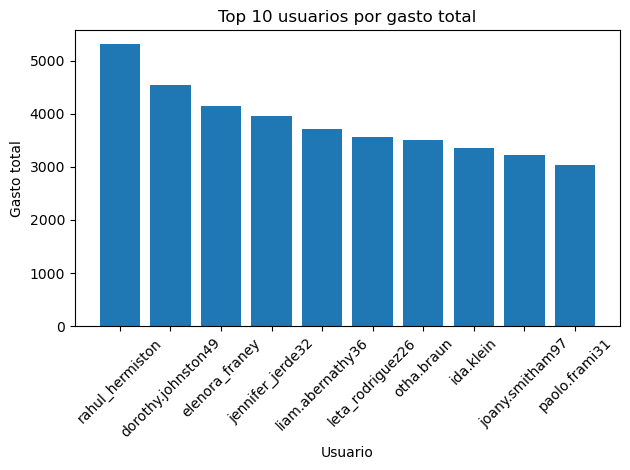

In [8]:

# 6.3) Top 10 usuarios por gasto total
top_gasto = (
    df_boletos
    .assign(precio=df_boletos['precio'].fillna(0))
    .groupby('usuario_id')['precio']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Agregar el nombre de usuario
top_gasto = top_gasto.merge(df_usuarios[['id','usuario','correo_electronico']], left_on='usuario_id', right_on='id', how='left')
top_gasto = top_gasto[['usuario_id','usuario','correo_electronico','precio']]
top_gasto.columns = ['usuario_id','usuario','correo_electronico','gasto_total']

display(top_gasto)

plt.figure()
plt.bar(top_gasto['usuario'].astype(str), top_gasto['gasto_total'].values)
plt.title('Top 10 usuarios por gasto total')
plt.xlabel('Usuario')
plt.ylabel('Gasto total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:

# =========================
# 7) Exportar resultados a CSV
# =========================
df_usuarios.to_csv('usuarios_export.csv', index=False, encoding='utf-8')
df_boletos.to_csv('boletos_export.csv', index=False, encoding='utf-8')
df_bu.to_csv('boletos_usuarios_export.csv', index=False, encoding='utf-8')

print("Archivos exportados:")
print("- usuarios_export.csv")
print("- boletos_export.csv")
print("- boletos_usuarios_export.csv")


Archivos exportados:
- usuarios_export.csv
- boletos_export.csv
- boletos_usuarios_export.csv
